In [0]:
#[1] import and installations
!pip install torchnet
!pip install PyDrive
!pip install mock
import torch
import numpy as np
from google.colab import files
import h5py
import torchnet as tnt
import functools
import mock
import math
import copy
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as nnf
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#[2] Authentification
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#[2] Authentification
downloaded = drive.CreateFile({'id':"1Gk2qvmtRzqE17bHP-dUQVWowLn6G2eXW"})
downloaded.GetContentFile('train_data.h5') 
downloaded = drive.CreateFile({'id':"1iRjdWqZ97kyBLJCC6iSLTcbmiC0LTVvP"})
downloaded.GetContentFile('test_data.h5')


In [0]:
#[4] building the train and test sets
test_file = h5py.File("test_data.h5",'r')
train_file = h5py.File("train_data.h5",'r')

test_list = []
for grp in test_file.keys():
  for subgrp in test_file[grp].keys():
    test_list.append(grp + "/" + subgrp)
       
train_list = []
for grp in train_file.keys():
  for subgrp in train_file[grp].keys():
    train_list.append(grp + "/" + subgrp)

#select 20 % of training data for validation    
valid_index = np.random.choice(len(train_list),int(len(train_list)/5), replace=False)
valid_list = [train_list[i] for i in valid_index]
train_list = [train_list[i] for i in np.setdiff1d(list(range(len(train_list))),valid_index)]
print("%d tiles in train set, %d tiles in test set, %d files in valid list" % (len(train_list), len(test_list), len(valid_list)))

class_names = ["ground", "vegetation", "building"]

720 tiles in train set, 100 tiles in test set, 180 files in valid list


In [0]:
#[4] data loader

def augment(cloud_data):
  """the augmentation function - leave untouched for now"""
  #random rotation around the Z axis
  angle = random.uniform(0, 2*math.pi)
  M = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
  cloud_data[:2] = np.dot(cloud_data[:2].T, M).T

  #random gaussian noise
  sigma, clip= 0.01, 0.03 # https://github.com/charlesq34/pointnet/blob/master/provider.py#L74
  cloud_data[:4] = cloud_data[:4] + np.clip(sigma * np.random.randn(*cloud_data[:4].shape), -1*clip, clip).astype(np.float32)
  return cloud_data


def cloud_loader(tile_name, train, cuda = 1):
  """
  load a tile and returns points features (normalized xyz + intensity) and 
  ground truth
  INPUT:
  tile_name = string, name of the tile
  train = int, train = 1 iff in the train set
  OUTPUT
  cloud_data, [n x 4] float array containing points coordinates and intensity
  labels, [n] long int array, containing the points semantic labels  
  """
  if train:
    cloud_data = train_file[tile_name]["data"].value.transpose()
  else:
    cloud_data = test_file[tile_name]["data"].value.transpose()
    
  gt = cloud_data[-1]
  gt[np.where(gt>3)] = 0
  
  if train:
    cloud_data = augment(cloud_data)
    
  cloud_data = torch.from_numpy(cloud_data[0:4])
  gt = torch.from_numpy(gt).long()
  
  if cuda:
    cloud_data = cloud_data.cuda()
    
  xmin, ymin, zmin = cloud_data.min(1)[0][0:3]
  xmax, ymax = cloud_data.max(1)[0][0:2]
  xmean, ymean = cloud_data.mean(1)[0:2]
  
  #normalizing on the unit cube
  cloud_data[0] = (cloud_data[0] - xmean)# / (xmax - xmin) #x turns out normalizing is detrimental for
  cloud_data[1] = (cloud_data[1] - ymean)# / (ymax - ymin) #y x and y values as well
  cloud_data[2] = (cloud_data[2] - zmin) #z
  cloud_data[3] = (cloud_data[3] - 50) / 20 #intensity
  
  return cloud_data, gt

def cloud_collate(batch):
    """ Collates a list of dataset samples into a batch list for clouds 
    and a single array for labels and
    """
    clouds, labels = list(zip(*batch))
    labels = torch.cat(labels, 0)
    return clouds, labels

test_set  = tnt.dataset.ListDataset(test_list,functools.partial(cloud_loader, train=False))
train_set = tnt.dataset.ListDataset(train_list,functools.partial(cloud_loader, train=True))
valid_set = tnt.dataset.ListDataset(valid_list,functools.partial(cloud_loader, train=True))

In [0]:
#[5] functions used for visualization
def view_intensity(cloud, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to its intensity"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d', aspect='equal')
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=cloud[3,:], s=2 \
               , cmap='hot', vmin=0, vmax=10);

def view_labels(cloud, labels, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to 'labels'"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d', aspect='equal')
  n_points = cloud.shape[1]
  colors = np.zeros((n_points,3))
  colors[np.where(labels.numpy()==1)] = [0.5,0.5,0.5] #ground
  colors[np.where(labels.numpy()==2)] = [0  ,0.6  ,0] #vegetation
  colors[np.where(labels.numpy()==3)] = [0  ,1  ,1] #building
  
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=colors, s=2);  
  
def view_error(cloud, pred, gt, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to green when 'gt'='pred', red when 'gt'!='pred' and black
  when the point in unnannotated (gt = 0)"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d', aspect='equal')
  n_points = cloud.shape[1]
  colors = np.zeros((n_points,3))
  colors[np.where(pred==gt)] = [0, 1, 0] #correct prediction
  colors[np.where(pred!=gt)] = [1, 0, 0] #error
  colors[np.where(gt==0)] = [0, 0, 0]   #unannotated
  
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=colors, s=2);
  
def view_testset(n_shown = 3, category = 'igpe', model = None, PCC = None):
  """ plot 'n_shown' point clouds from the test set with the following color
  codes:
  if 'i' in category : intensity
  if 'g' in category : ground truth
  if 'p' in category : prediction
  if 'e' in category : error
  Note that for 'p' or 'e' ou need to add a trained model as input
  
  """
  n_category = len(category)
  fig = plt.figure(figsize=(n_category * 7, n_shown * 7))
  
  index_image = 1
  for test_cloud in random.sample(test_list,n_shown):
    
    cloud, gt = cloud_loader(test_cloud, 0, cuda=0)
    
    if 'p' in category or 'e' in category:
      pred = PCC.run(model, [cloud])
    
    if 'i' in category:
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d' , aspect='equal')
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='Intensity')
      view_intensity(cloud, ax = ax)
      index_image += 1
    if 'g' in category:  
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d', aspect='equal')
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='Ground Truth')
      view_labels(cloud, gt, ax = ax)
      index_image += 1
    if 'p' in category: 
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d', aspect='equal')
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category :
        ax.set(title='Prediction')
      view_labels(cloud, pred.argmax(1).cpu()+1, ax = ax)
      index_image += 1
    if 'e' in category: 
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d', aspect='equal')
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='error')
      view_error(cloud, pred.argmax(1).cpu()+1, gt, ax = ax)
      index_image += 1
  plt.show()

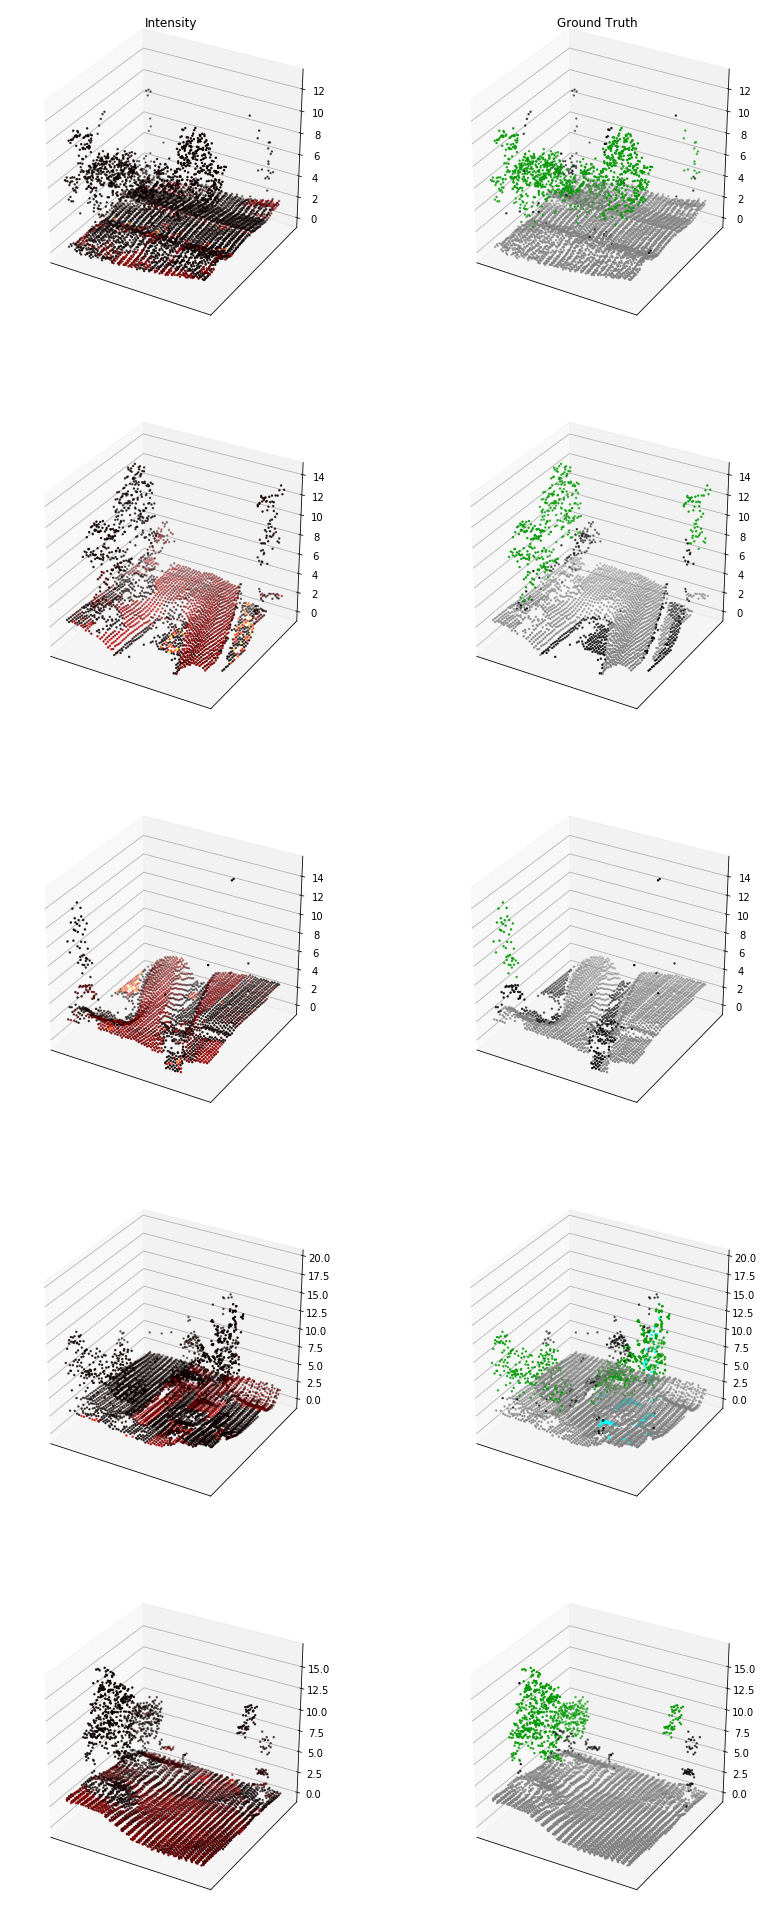

In [0]:
#[6]
view_testset(n_shown = 5, category = 'ig')

In [0]:
#[7]
class PointNet(nn.Module):
  """
  The PointNet network for semantic segmentation
  """
  
  def __init__(self, MLP_1, MLP_2, MLP_3, n_class = 3, input_feat=4, subsample_size = 512, cuda = 1):
    """
    initialization function
    MLP_1, LMP2 and MLP3 = int array, size of the layers
    n_class = int,  the number of class
    input_feat = int, number of input feature
    subsample_size = int, number of points to which the tiles are subsampled
    
    """
    
    super(PointNet, self).__init__() #necessary for all classes extending the module class
    
    self.subsample_size = subsample_size
    
    m1 = MLP_1[-1] #size of the first embeding F1
    m2 = MLP_2[-1] #size of the second embeding F2
    
    modules = []
    for i in range(len(MLP_1)):
      modules.append(nn.Conv1d(MLP_1[i-1] if i>0 else input_feat, MLP_1[i], 1))
      modules.append(nn.BatchNorm1d(MLP_1[i]))
      modules.append(nn.ReLU(True))
    self.MLP_1 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_2)):
      modules.append(nn.Conv1d(MLP_2[i-1] if i>0 else m1, MLP_2[i], 1))
      modules.append(nn.BatchNorm1d(MLP_2[i]))
      modules.append(nn.ReLU(True))
    self.MLP_2 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_3)):
      modules.append(nn.Conv1d(MLP_3[i-1] if i>0 else m1 + m2, MLP_3[i], 1))
      modules.append(nn.BatchNorm1d(MLP_3[i]))
      modules.append(nn.ReLU(True))
      
    modules.append(nn.Dropout(0.3))
    modules.append(nn.Conv1d(MLP_3[-1], n_class,1))
    self.MLP_3 = nn.Sequential(*modules)
    
    self.maxpool = nn.MaxPool1d(subsample_size)
    
    
    
    if cuda:
      self = self.cuda()
    
  def forward(self, input):
    """
    the forward function producing the embeddings for each point of 'input'
    input = [n_batch, input_feat, subsample_size] float array: input features
    output = [n_batch,n_class, subsample_size] float array: point class logits
    """
    #embed points, equation (1)
    embed = self.MLP_1(input) 
    #process embeddings and maxpool, equation (2) and (3)
    global_embed = self.maxpool(self.MLP_2(embed))
    #concatenate f1 and G and perform equation(4)
    class_scores = self.MLP_3(torch.cat((global_embed.repeat(1,1,self.subsample_size), embed),1))
    #avoid wasting by not using intermediary variables
    return class_scores

#==================TEST===============================
#we consider the first point cloud from the training set
cloud_data, gt = cloud_loader(train_list[0], 1, cuda = 1)
#to create a proper input for the pointnet we need to we add one empty dimension
#for the batch size (with keyword None), and subsample the point cloud to have
#subsample_size = 512 points
cloud_data = cloud_data[None,:,:512] 
#we now create a pointnet model:
ptn = PointNet([32,32], [32,64,256], [128,64,32], n_class = 3, input_feat=4, subsample_size = 512)
print(ptn)
#we now test that the code works correctly
pred = ptn.forward(cloud_data)
#we now check that the size is indeed [n_batch,n_class, subsample_size]
assert(pred.shape == torch.Size([1,3,512]))

PointNet(
  (MLP_1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
  (MLP_2): Sequential(
    (0): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
  )
  (MLP_3): Sequential(
    (0): Conv1d(288, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d

In [0]:
#[8]
class PointCloudClassifier:
  """
  The main point cloud classifier Class
  """
  def __init__(self, args):
    self.subsample_size = args.subsample_size
    self.n_input_feats = 3
    if 'i' in args.input_feats: #add intensity
      self.n_input_feats += 1
    self.n_class = args.n_class
    self.cuda = args.cuda
  
  def run(self, model, clouds):
    """
    INPUT:
    model = the neural network
    clouds = list of n bacthges array of size [n_feat, n_points_i] float arrays: batch of point clouds
    OUTPUT:
    pred = [sum_i n_points_i,n_class] float arrays : prediction for each element of the 
         batch in a single array
    
    """
    
    #will contain the prediction for all elements in the batch
    batch_pred   = torch.zeros((self.n_class,0))
    
    #will contain all the features for the clouds in batch subsampled to the same size
    batch_data = torch.Tensor((len(clouds)), self.n_input_feats, self.subsample_size)
    if self.cuda:
      batch_data = batch_data.cuda()
      batch_pred = batch_pred.cuda()
    
    for i_elem in range(len(clouds)):
      #load the elements in the batch one by one and subsample/ oversample them
      #to self.subsample_size points
            
      elem_data = clouds[i_elem][:int(self.n_input_feats),:]
      
      n_points = elem_data.shape[1]      

      #check the number of points
      if n_points >= self.subsample_size: # need to subsample to self.subsample_size points
        selected_points = np.random.choice(n_points, self.subsample_size, replace = False)
        elem_data = elem_data[:,selected_points]
        
      elif n_points < self.subsample_size: # need to pad by duplication
        selected_points = np.random.choice(n_points, self.subsample_size - n_points)
        elem_data = torch.cat((elem_data,elem_data[:,selected_points]), dim=1)
        
      batch_data[i_elem,:,:] = elem_data.clone()
    
    prediction = model.ptn(batch_data) #process the 
    
    for i_elem in range(len(clouds)):
      
      elem_data = clouds[i_elem]
      elem_data_selected = batch_data[i_elem,:3,:]      
            
      n_points = elem_data.shape[1]
      
      if n_points >= self.subsample_size: # subsampled
        #we need to interpolate the prediction to the entire point cloud)
        nn = NearestNeighbors(1, algorithm='kd_tree').fit( \
             elem_data_selected.cpu().permute(1,0))
        dump, closest_point = nn.kneighbors(elem_data[:3,:].permute(1,0).cpu())
        
        full_pred = prediction[i_elem, :, closest_point].squeeze()
      else:
        #select original n_points
        full_pred = prediction[i_elem,:,:n_points]
      batch_pred = torch.cat((batch_pred, full_pred),1)
      #batch_labels = torch.cat((batch_labels, elem_data[-1,:]))
    return batch_pred.permute(1,0)

#==================TEST===============================
#we consider the first point cloud from the training set
cloud1= cloud_loader(train_list[0], 1, cuda = 1)
cloud2 = cloud_loader(train_list[1], 1, cuda = 1)
#we artifically decrease the number of points in cloud2 in order to test both 
#subample and oversample cases
cloud2 = (cloud2[0][:,:200], cloud2[1][:200])
print("Loading two clouds with %d  and %d points respectively" \
      % (cloud1[0].shape[1], cloud2[0].shape[1]))
#we use the collate function to batch the two clouds
batch_clouds, gt = cloud_collate((cloud1, cloud2))

#we create a parameter structure to parameterize a classifier
args = mock.Mock()
args.n_class = 3
args.input_feats = 'xyzi'
args.subsample_size = 512
#we create an instace of PointCloudClassifier
PCC = PointCloudClassifier(args)
#we create a model
model = nn.Module()
model.ptn = PointNet([32,32], [32,64,256], [128,64,32], n_class = 3, \
                     input_feat=4, subsample_size = 512, cuda = 1)
#we now launch the prediction:
pred = PCC.run(model, batch_clouds)
#we check that the size of the prediction is indeed [sum_i n_points_i,n_class]
assert(pred.shape == torch.Size((cloud1[0].shape[1] + cloud2[0].shape[1],3)))

Loading two clouds with 5149  and 200 points respectively


In [0]:
#[9]
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
  def overall_accuracy(self):#percentage of correct classification
    return 100*self.CM.trace() / self.CM.sum()

  def class_IoU(self, show = 1):
    ious = np.full(self.n_class, 0.)
    for i_class in range(self.n_class):
      ious[i_class] = self.CM[i_class, i_class] / \
        (-self.CM[i_class, i_class] \
        + self.CM[i_class, :].sum()
        + self.CM[:, i_class].sum())
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [0]:
#[10]
m = ConfusionMatrix(3, class_names)
m.add_batch(np.array([0,1,1,1,2,0,0]), np.array([0,1,1,1,2,0,0]))
m.add_batch(np.array([0,1,1,1,2,1,0]), np.array([0,0,1,1,0,0,0]))
print(m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()
m.clear()

[[5. 0. 0.]
 [2. 5. 0.]
 [1. 0. 1.]]
OA = 78.57%
ground : 62.50%  |  vegetation : 71.43%  |  building : 50.00%


In [0]:
#[11]
def train(model, PCC, optimizer, args):
  """train for one epoch"""
  model.train()
  
  #the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, collate_fn=cloud_collate, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=50)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for ind_batc, (cloud, gt) in enumerate(loader):
    
    optimizer.zero_grad() #put gradient to zero
    
    pred = PCC.run(model, cloud) #compute the prediction

    labeled = gt!=0 #remove the unlabelled points from the supervision
    if labeled.sum() == 0:
      continue #no labeled points, skip
    
    loss = nn.functional.cross_entropy(pred[labeled].cpu(), gt[labeled]-1, weight=torch.Tensor(args.class_weight)) 

    loss.backward() #compute gradients
    
    for p in model.parameters(): #we clip the gradient at norm 1
      p.grad.data.clamp_(-1, 1)
    
    optimizer.step() #one SGD step
    
    loss_meter.add(loss.item())
    cm.add_batch(gt[labeled]-1, pred[labeled].argmax(1).cpu().detach().numpy())
  return cm, loss_meter.value()[0]



def eval(model, PCC, args, test = True):
  """eval on test/validation set"""
  
  model.eval()
  
  if test:
    loader = torch.utils.data.DataLoader(test_set, collate_fn=cloud_collate, batch_size=1, shuffle=False)
  else:
    loader = torch.utils.data.DataLoader(valid_set, collate_fn=cloud_collate, batch_size=60, shuffle=False, drop_last=False)
  
  loader = tqdm(loader, ncols=50)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for ind_batc, (cloud, gt) in enumerate(loader):
    
    avg_pred = torch.zeros(len(gt), args.n_class, device = cloud[0].device)
    
    for i in range(args.n_votes_eval):
      #we average the class cores over n_votes_eval runs
      avg_pred += PCC.run(model, cloud)  
    
    avg_pred = avg_pred / args.n_votes_eval
    
    labeled = gt!=0 #we remove the unlabelled points from the supervision
    if labeled.sum() == 0:
      continue #no labeled points, skip
    
    loss = nn.functional.cross_entropy(avg_pred[labeled].cpu(), gt[labeled]-1, weight=torch.Tensor(args.class_weight)) 
    
    loss_meter.add(loss.item())
    cm.add_batch(gt[labeled]-1, avg_pred[labeled].argmax(1).cpu().detach().numpy())
  return cm, loss_meter.value()[0]



def train_full(args):
  """The full training loop"""
  #initialize the model
  model = nn.Module()
  model.ptn = PointNet(args.MLP_1, args.MLP_2, args.MLP_3, args.n_class, input_feat=args.n_input_feats, subsample_size = args.subsample_size)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  print(model)
  
  best_model = 0
  best_loss = 1000

  #define the classifier
  PCC = PointCloudClassifier(args)
  
  #define the optimizer
  #adam optimizer is always a good guess for classification
  optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
  #adding a scheduler for adaptive learning rate. at each milestone lr_steps 
  #the learning rate is multiplied by lr_decay
  scheduler = MultiStepLR(optimizer, milestones=args.lr_steps, gamma=args.lr_decay)
  
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  VALIDCOLOR = '\033[45m'
  NORMALCOLOR = '\033[0m'
  
  for i_epoch in range(args.n_epoch):
    #train one epoch
    scheduler.step() #update the scheduler
    cm_train, loss_train = train(model, PCC, optimizer, args)
    print(TRAINCOLOR)
    mIoU = cm_train.class_IoU()
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), mIoU, loss_train) + NORMALCOLOR)

    cm_valid, loss_valid = eval(model, PCC, args, test=False)
    best_valid = False
    
    if loss_valid < best_loss:
      best_valid = True
      best_loss = loss_valid
      print(VALIDCOLOR)
      mIoU = cm_valid.class_IoU()
      best_model = copy.deepcopy(model)
      print('-> Best performance achieved: Overall Accuracy: %3.2f%% valid mIoU : %3.2f%% valid Loss: %1.4f' % (cm_valid.overall_accuracy(), mIoU, loss_valid) + NORMALCOLOR)

    if i_epoch % args.n_epoch_test == 0 and (best_valid or  i_epoch == args.n_epoch - 1):
      #periodic testing
      cm_test, loss_test = eval(best_model, PCC, args)
      print(TESTCOLOR)
      mIoU = cm_test.class_IoU()
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), mIoU, loss_test) + NORMALCOLOR)
      
  return best_model, PCC

In [0]:
#[12]
args = mock.Mock()
args.n_epoch = 50
args.n_epoch_test = int(1)
args.batch_size = 16
args.n_class = 3
args.input_feats = 'xyzi'
args.n_input_feats = 4
args.MLP_1 = [32,32]
args.MLP_2 = [32,64,256]
args.MLP_3 = [128,64,32]
args.subsample_size = 512
args.cuda = 1
args.lr = 5e-3
args.wd = 0
args.n_votes_eval = 5
args.lr_steps = [20,35,45]
args.lr_decay = 0.7
args.class_weight = [0.2,0.3,0.5]

trained_model, PCC = train_full(args)

Total number of parameters: 69731
Module(
  (ptn): PointNet(
    (MLP_1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
    (MLP_2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace)
    )
    (MLP_3)



ground : 85.53%  |  vegetation : 57.25%  |  building : 8.13%
Epoch   0 -> Train Overall Accuracy: 80.83% Train mIoU : 50.30% Train Loss: 0.6651




ground : 95.62%  |  vegetation : 68.75%  |  building : 25.49%
-> Best performance achieved: Overall Accuracy: 87.93% valid mIoU : 63.28% valid Loss: 0.4698




ground : 95.56%  |  vegetation : 68.72%  |  building : 25.56%
Test Overall Accuracy: 88.95% Test mIoU : 63.28%  Test Loss: 0.4109




ground : 95.24%  |  vegetation : 64.22%  |  building : 34.75%
Epoch   1 -> Train Overall Accuracy: 86.64% Train mIoU : 64.74% Train Loss: 0.4339




ground : 96.91%  |  vegetation : 71.03%  |  building : 29.99%
-> Best performance achieved: Overall Accuracy: 88.88% valid mIoU : 65.98% valid Loss: 0.3837




ground : 97.13%  |  vegetation : 72.57%  |  building : 33.94%
Test Overall Accuracy: 90.48% Test mIoU : 67.88%  Test Loss: 0.3563




ground : 95.78%  |  vegetation : 66.69%  |  building : 41.00%
Epoch   2 -> Train Overall Accuracy: 88.02% Train mIoU : 67.82% Train Loss: 0.4078




ground : 96.20%  |  vegetation : 67.70%  |  building : 40.49%
Epoch   3 -> Train Overall Accuracy: 88.40% Train mIoU : 68.13% Train Loss: 0.3990




ground : 95.94%  |  vegetation : 70.09%  |  building : 43.78%
Epoch   4 -> Train Overall Accuracy: 89.11% Train mIoU : 69.94% Train Loss: 0.3869




ground : 96.06%  |  vegetation : 69.28%  |  building : 42.96%
Epoch   5 -> Train Overall Accuracy: 88.95% Train mIoU : 69.44% Train Loss: 0.3883




ground : 96.82%  |  vegetation : 60.52%  |  building : 43.87%
-> Best performance achieved: Overall Accuracy: 87.71% valid mIoU : 67.07% valid Loss: 0.3738




ground : 97.69%  |  vegetation : 55.50%  |  building : 40.84%
Test Overall Accuracy: 88.05% Test mIoU : 64.67%  Test Loss: 0.3492




ground : 96.11%  |  vegetation : 69.88%  |  building : 43.53%
Epoch   6 -> Train Overall Accuracy: 89.18% Train mIoU : 69.84% Train Loss: 0.3839




ground : 96.61%  |  vegetation : 70.12%  |  building : 44.97%
Epoch   7 -> Train Overall Accuracy: 89.53% Train mIoU : 70.57% Train Loss: 0.3735




ground : 96.18%  |  vegetation : 69.95%  |  building : 44.27%
Epoch   8 -> Train Overall Accuracy: 89.23% Train mIoU : 70.13% Train Loss: 0.3797




ground : 96.23%  |  vegetation : 70.80%  |  building : 45.75%
Epoch   9 -> Train Overall Accuracy: 89.61% Train mIoU : 70.93% Train Loss: 0.3745




ground : 97.27%  |  vegetation : 67.36%  |  building : 49.26%
-> Best performance achieved: Overall Accuracy: 89.54% valid mIoU : 71.29% valid Loss: 0.3306




ground : 98.38%  |  vegetation : 68.85%  |  building : 51.89%
Test Overall Accuracy: 91.62% Test mIoU : 73.04%  Test Loss: 0.2847




ground : 96.74%  |  vegetation : 72.01%  |  building : 47.01%
Epoch  10 -> Train Overall Accuracy: 90.18% Train mIoU : 71.92% Train Loss: 0.3610




ground : 98.13%  |  vegetation : 73.40%  |  building : 54.71%
-> Best performance achieved: Overall Accuracy: 91.74% valid mIoU : 75.41% valid Loss: 0.2966




ground : 98.65%  |  vegetation : 72.58%  |  building : 55.70%
Test Overall Accuracy: 92.77% Test mIoU : 75.64%  Test Loss: 0.2460




ground : 96.86%  |  vegetation : 71.97%  |  building : 48.25%
Epoch  11 -> Train Overall Accuracy: 90.32% Train mIoU : 72.36% Train Loss: 0.3560




ground : 96.54%  |  vegetation : 70.75%  |  building : 46.06%
Epoch  12 -> Train Overall Accuracy: 89.74% Train mIoU : 71.12% Train Loss: 0.3655




ground : 96.90%  |  vegetation : 72.73%  |  building : 49.10%
Epoch  13 -> Train Overall Accuracy: 90.60% Train mIoU : 72.91% Train Loss: 0.3508




ground : 96.43%  |  vegetation : 72.34%  |  building : 46.89%
Epoch  14 -> Train Overall Accuracy: 90.13% Train mIoU : 71.89% Train Loss: 0.3634




ground : 96.56%  |  vegetation : 73.85%  |  building : 49.74%
Epoch  15 -> Train Overall Accuracy: 90.73% Train mIoU : 73.38% Train Loss: 0.3461




ground : 97.06%  |  vegetation : 73.54%  |  building : 50.11%
Epoch  16 -> Train Overall Accuracy: 90.92% Train mIoU : 73.57% Train Loss: 0.3402




ground : 96.93%  |  vegetation : 73.96%  |  building : 50.08%
Epoch  17 -> Train Overall Accuracy: 90.94% Train mIoU : 73.66% Train Loss: 0.3412




ground : 96.83%  |  vegetation : 75.12%  |  building : 50.01%
Epoch  18 -> Train Overall Accuracy: 91.18% Train mIoU : 73.99% Train Loss: 0.3402




ground : 96.90%  |  vegetation : 74.88%  |  building : 51.34%
Epoch  19 -> Train Overall Accuracy: 91.24% Train mIoU : 74.38% Train Loss: 0.3331




ground : 97.05%  |  vegetation : 73.58%  |  building : 49.85%
Epoch  20 -> Train Overall Accuracy: 90.92% Train mIoU : 73.50% Train Loss: 0.3409




ground : 98.09%  |  vegetation : 67.06%  |  building : 52.53%
-> Best performance achieved: Overall Accuracy: 90.22% valid mIoU : 72.56% valid Loss: 0.2959




ground : 99.22%  |  vegetation : 70.07%  |  building : 58.87%
Test Overall Accuracy: 92.79% Test mIoU : 76.05%  Test Loss: 0.2267




ground : 97.05%  |  vegetation : 75.32%  |  building : 52.92%
Epoch  21 -> Train Overall Accuracy: 91.49% Train mIoU : 75.10% Train Loss: 0.3233




ground : 97.04%  |  vegetation : 75.13%  |  building : 52.60%
Epoch  22 -> Train Overall Accuracy: 91.49% Train mIoU : 74.92% Train Loss: 0.3251




ground : 96.74%  |  vegetation : 75.56%  |  building : 51.55%
Epoch  23 -> Train Overall Accuracy: 91.34% Train mIoU : 74.62% Train Loss: 0.3286




ground : 97.12%  |  vegetation : 76.08%  |  building : 53.09%
Epoch  24 -> Train Overall Accuracy: 91.73% Train mIoU : 75.43% Train Loss: 0.3177




ground : 97.21%  |  vegetation : 76.61%  |  building : 53.28%
Epoch  25 -> Train Overall Accuracy: 91.89% Train mIoU : 75.70% Train Loss: 0.3170




ground : 97.48%  |  vegetation : 76.41%  |  building : 55.38%
Epoch  26 -> Train Overall Accuracy: 92.14% Train mIoU : 76.42% Train Loss: 0.3074




ground : 97.20%  |  vegetation : 77.09%  |  building : 54.54%
Epoch  27 -> Train Overall Accuracy: 92.09% Train mIoU : 76.28% Train Loss: 0.3115




ground : 98.22%  |  vegetation : 80.84%  |  building : 56.87%
-> Best performance achieved: Overall Accuracy: 93.49% valid mIoU : 78.64% valid Loss: 0.2627




ground : 98.96%  |  vegetation : 80.68%  |  building : 59.30%
Test Overall Accuracy: 94.57% Test mIoU : 79.65%  Test Loss: 0.2114




ground : 97.12%  |  vegetation : 76.89%  |  building : 53.45%
Epoch  28 -> Train Overall Accuracy: 91.92% Train mIoU : 75.82% Train Loss: 0.3120




ground : 97.41%  |  vegetation : 77.27%  |  building : 55.62%
Epoch  29 -> Train Overall Accuracy: 92.28% Train mIoU : 76.77% Train Loss: 0.3033




ground : 98.26%  |  vegetation : 77.79%  |  building : 60.83%
-> Best performance achieved: Overall Accuracy: 93.09% valid mIoU : 78.96% valid Loss: 0.2527




ground : 98.14%  |  vegetation : 78.62%  |  building : 59.91%
Test Overall Accuracy: 93.84% Test mIoU : 78.89%  Test Loss: 0.2163




ground : 97.47%  |  vegetation : 78.28%  |  building : 56.57%
Epoch  30 -> Train Overall Accuracy: 92.61% Train mIoU : 77.44% Train Loss: 0.2985




ground : 97.19%  |  vegetation : 76.69%  |  building : 54.07%
Epoch  31 -> Train Overall Accuracy: 91.96% Train mIoU : 75.98% Train Loss: 0.3121




ground : 97.38%  |  vegetation : 77.63%  |  building : 55.58%
Epoch  32 -> Train Overall Accuracy: 92.36% Train mIoU : 76.87% Train Loss: 0.3039




ground : 97.06%  |  vegetation : 76.99%  |  building : 54.20%
Epoch  33 -> Train Overall Accuracy: 91.97% Train mIoU : 76.08% Train Loss: 0.3123




ground : 97.44%  |  vegetation : 77.97%  |  building : 56.13%
Epoch  34 -> Train Overall Accuracy: 92.49% Train mIoU : 77.18% Train Loss: 0.2987




ground : 97.20%  |  vegetation : 78.70%  |  building : 56.28%
Epoch  35 -> Train Overall Accuracy: 92.55% Train mIoU : 77.39% Train Loss: 0.2964




ground : 97.28%  |  vegetation : 78.67%  |  building : 56.68%
Epoch  36 -> Train Overall Accuracy: 92.60% Train mIoU : 77.54% Train Loss: 0.2976




ground : 97.35%  |  vegetation : 78.54%  |  building : 56.51%
Epoch  37 -> Train Overall Accuracy: 92.59% Train mIoU : 77.47% Train Loss: 0.2945




ground : 97.50%  |  vegetation : 78.15%  |  building : 56.30%
Epoch  38 -> Train Overall Accuracy: 92.57% Train mIoU : 77.32% Train Loss: 0.2961




ground : 97.45%  |  vegetation : 78.58%  |  building : 57.41%
Epoch  39 -> Train Overall Accuracy: 92.71% Train mIoU : 77.81% Train Loss: 0.2871




ground : 97.37%  |  vegetation : 78.08%  |  building : 56.14%
Epoch  40 -> Train Overall Accuracy: 92.48% Train mIoU : 77.20% Train Loss: 0.2944




ground : 97.43%  |  vegetation : 79.51%  |  building : 58.34%
Epoch  41 -> Train Overall Accuracy: 92.95% Train mIoU : 78.42% Train Loss: 0.2843




ground : 97.47%  |  vegetation : 78.85%  |  building : 57.47%
Epoch  42 -> Train Overall Accuracy: 92.78% Train mIoU : 77.93% Train Loss: 0.2881




ground : 97.38%  |  vegetation : 79.19%  |  building : 57.51%
Epoch  43 -> Train Overall Accuracy: 92.81% Train mIoU : 78.02% Train Loss: 0.2855




ground : 97.32%  |  vegetation : 79.30%  |  building : 57.99%
Epoch  44 -> Train Overall Accuracy: 92.84% Train mIoU : 78.20% Train Loss: 0.2845




ground : 97.75%  |  vegetation : 80.04%  |  building : 60.09%
Epoch  45 -> Train Overall Accuracy: 93.34% Train mIoU : 79.30% Train Loss: 0.2732




ground : 97.59%  |  vegetation : 79.37%  |  building : 58.87%
Epoch  46 -> Train Overall Accuracy: 93.05% Train mIoU : 78.61% Train Loss: 0.2755




ground : 97.73%  |  vegetation : 80.09%  |  building : 60.21%
Epoch  47 -> Train Overall Accuracy: 93.32% Train mIoU : 79.34% Train Loss: 0.2726




ground : 98.73%  |  vegetation : 81.40%  |  building : 64.93%
-> Best performance achieved: Overall Accuracy: 94.31% valid mIoU : 81.69% valid Loss: 0.2297




ground : 99.04%  |  vegetation : 81.74%  |  building : 67.17%
Test Overall Accuracy: 95.22% Test mIoU : 82.65%  Test Loss: 0.1740




ground : 97.71%  |  vegetation : 79.65%  |  building : 59.39%
Epoch  48 -> Train Overall Accuracy: 93.19% Train mIoU : 78.92% Train Loss: 0.2754




ground : 97.72%  |  vegetation : 79.81%  |  building : 59.26%
Epoch  49 -> Train Overall Accuracy: 93.21% Train mIoU : 78.93% Train Loss: 0.2714




ground : 98.93%  |  vegetation : 81.86%  |  building : 66.88%
Test Overall Accuracy: 95.18% Test mIoU : 82.56%  Test Loss: 0.1752


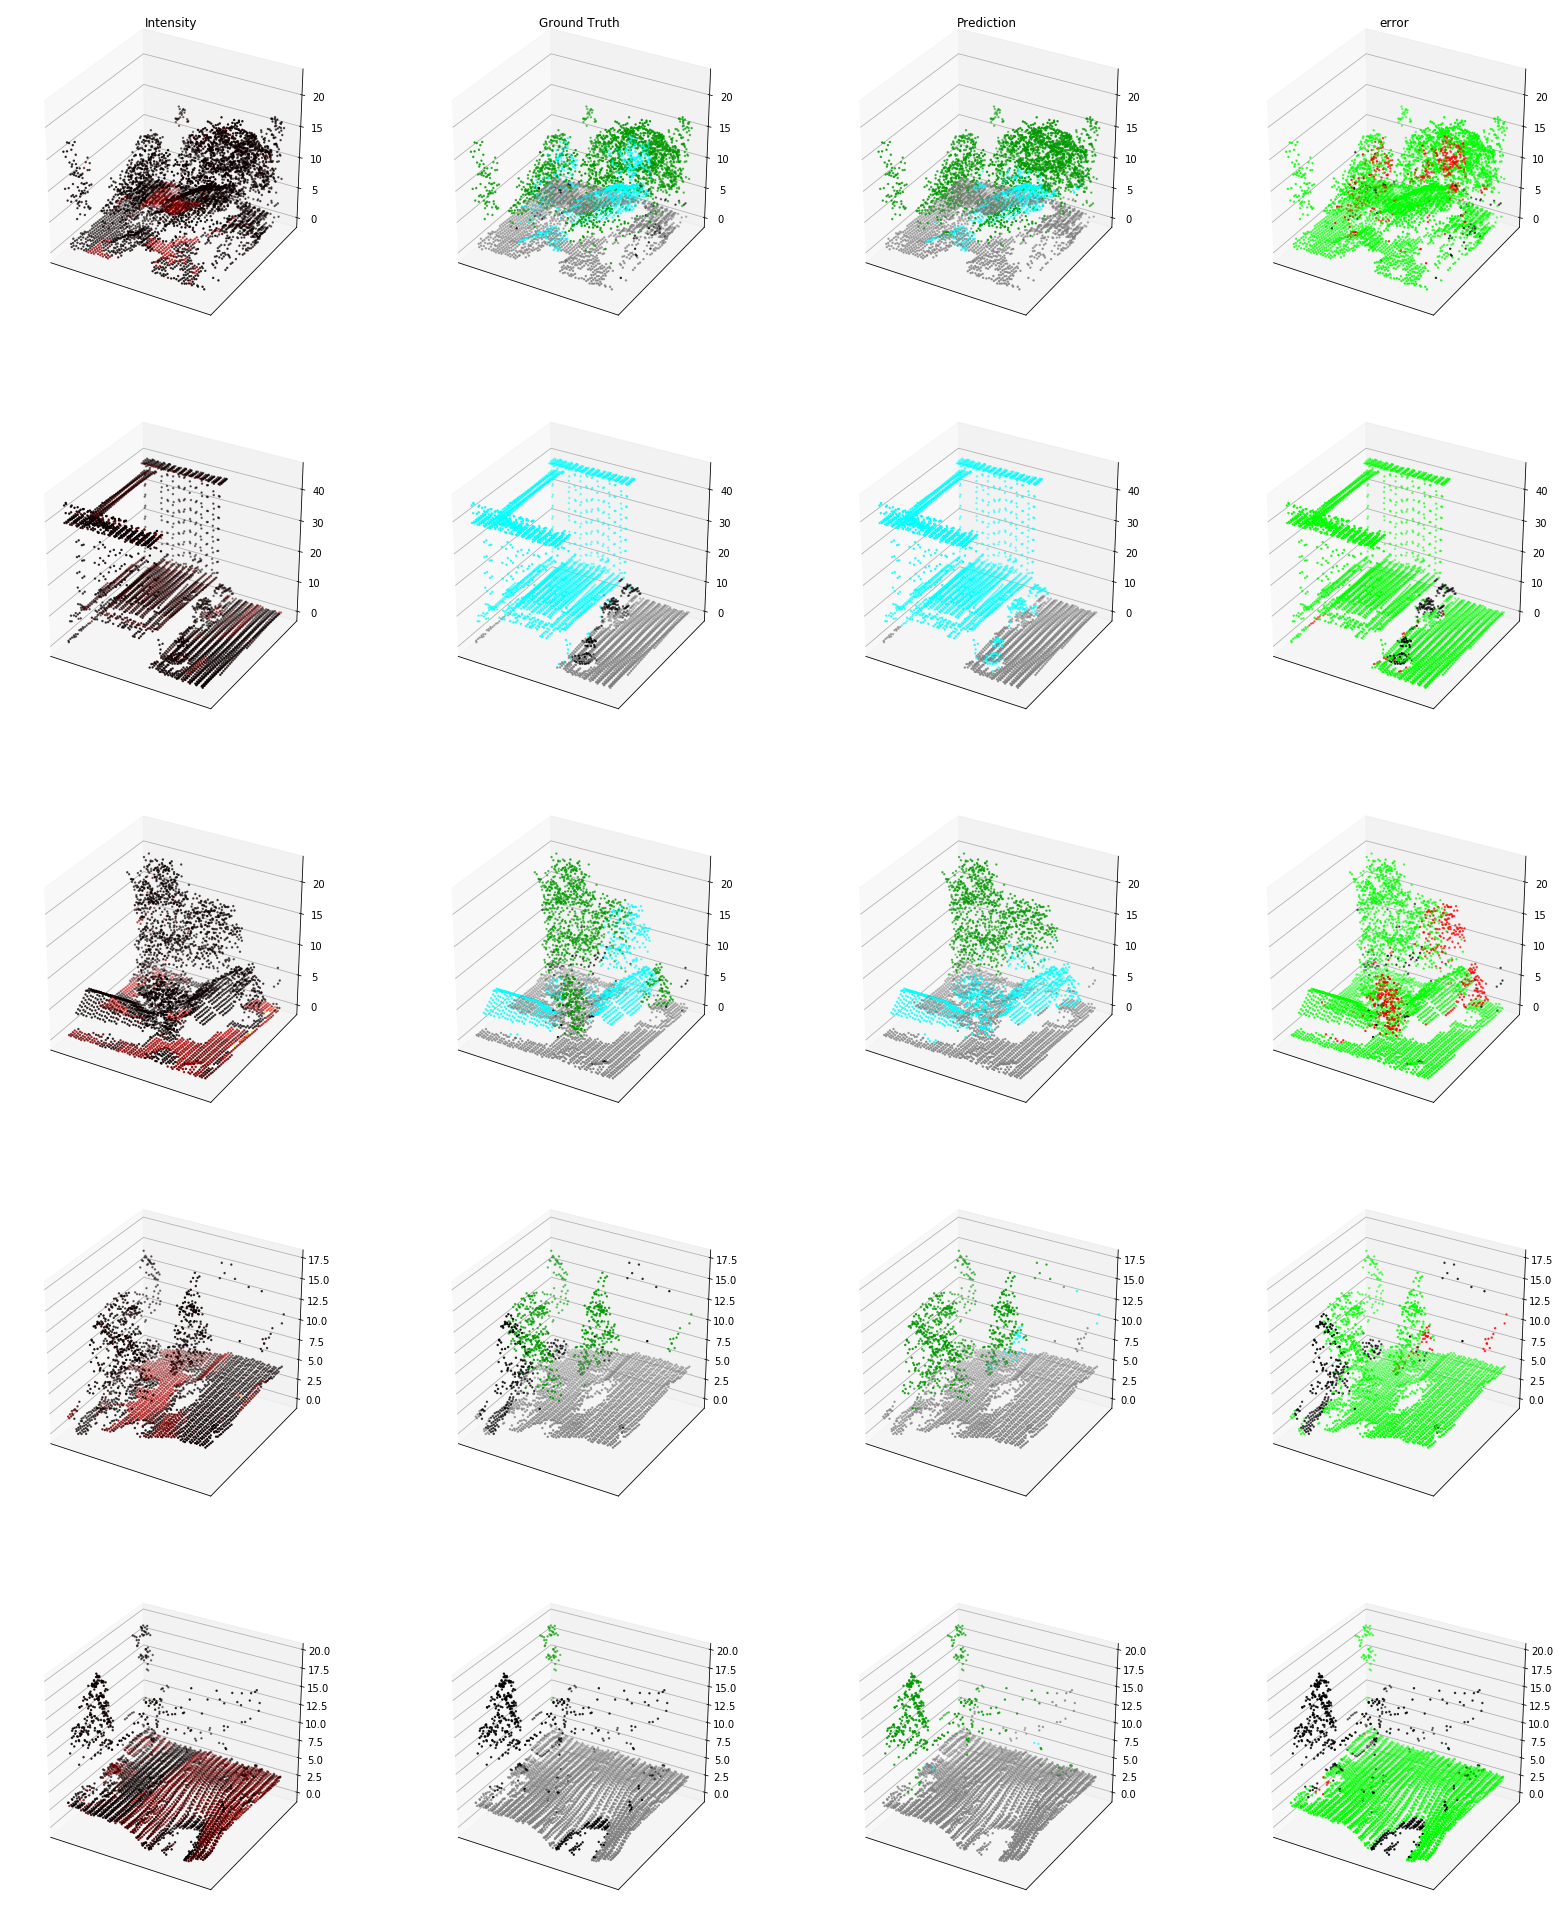

In [0]:
view_testset(n_shown = 5, category = 'igpe', model = trained_model, PCC = PCC)
  